In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py, glob
import pandas as pd

from ang_res_funcs import *

In [2]:
PARENT_DIRECTORY = '/data/ana/CosmicRay/Anisotropy/IceTop/twelve_year/03_sim_study'
DIRECTS = ['/home/rchapagain/arrays_no_simweights_2012', '/home/rchapagain/arrays_2012', f'{PARENT_DIRECTORY}/IT81-2015', f'{PARENT_DIRECTORY}/IT81-2018']

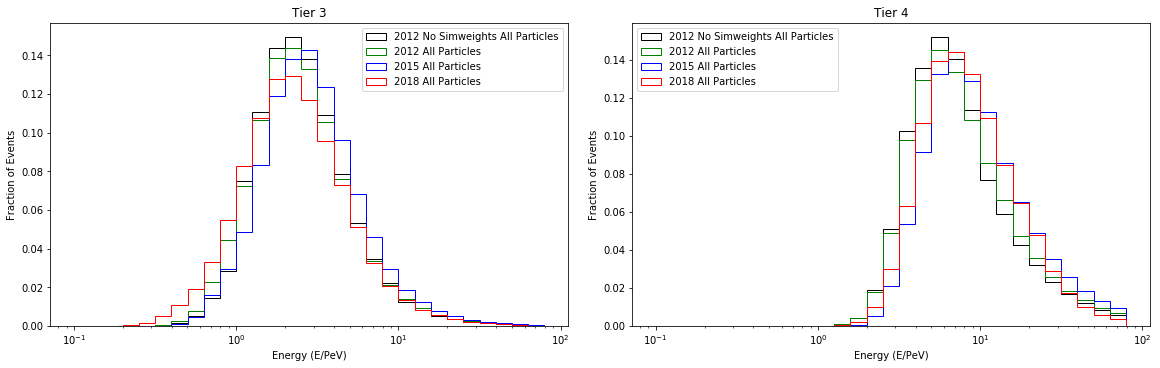

In [3]:
histograms = plt.figure(figsize=(16, 5), constrained_layout=True)
hist_array = histograms.subplots(1, 2, squeeze=False)

for i, DIRECT in enumerate(DIRECTS):
    # LOAD FILES
    
    #Stations
    ns_p_t1 = np.load(DIRECT +'/Proton-T1-Stations.npy')
    ns_he_t1 = np.load(DIRECT +'/Helium-T1-Stations.npy')
    ns_o_t1 = np.load(DIRECT +'/Oxygen-T1-Stations.npy')
    ns_fe_t1 = np.load(DIRECT +'/Iron-T1-Stations.npy')
    
    
    # MONTE CARLO
    
    # Zenith

    if DIRECT.endswith('2012'):
        mc_zen_p_t1 = np.load(DIRECT +'/Proton-T3-MC-Zenith.npy')
        mc_zen_he_t1 = np.load(DIRECT +'/Helium-T3-MC-Zenith.npy')
        mc_zen_o_t1 = np.load(DIRECT +'/Oxygen-T3-MC-Zenith.npy')
        mc_zen_fe_t1 = np.load(DIRECT +'/Iron-T3-MC-Zenith.npy')
    else:
        mc_zen_p_t1 = np.load(DIRECT +'/Proton-T1-MC-Zenith.npy')
        mc_zen_he_t1 = np.load(DIRECT +'/Helium-T1-MC-Zenith.npy')
        mc_zen_o_t1 = np.load(DIRECT +'/Oxygen-T1-MC-Zenith.npy')
        mc_zen_fe_t1 = np.load(DIRECT +'/Iron-T1-MC-Zenith.npy')
    
    # mc_zen_p_t2 = np.load(DIRECT +'/Proton-T2-MC-Zenith.npy')
    # mc_zen_he_t2 = np.load(DIRECT +'/Helium-T2-MC-Zenith.npy')
    # mc_zen_o_t2 = np.load(DIRECT +'/Oxygen-T2-MC-Zenith.npy')
    # mc_zen_fe_t2 = np.load(DIRECT +'/Iron-T2-MC-Zenith.npy')
    
    # mc_zen_p_t3 = np.load(DIRECT +'/Proton-T3-MC-Zenith.npy')
    # mc_zen_he_t3 = np.load(DIRECT +'/Helium-T3-MC-Zenith.npy') 
    # mc_zen_o_t3 = np.load(DIRECT +'/Oxygen-T3-MC-Zenith.npy')
    # mc_zen_fe_t3 = np.load(DIRECT +'/Iron-T3-MC-Zenith.npy')
    
    mc_zen_p_t4 = np.load(DIRECT +'/Proton-T4-MC-Zenith.npy') 
    mc_zen_he_t4 = np.load(DIRECT +'/Helium-T4-MC-Zenith.npy') 
    mc_zen_o_t4 = np.load(DIRECT +'/Oxygen-T4-MC-Zenith.npy')
    mc_zen_fe_t4 = np.load(DIRECT +'/Iron-T4-MC-Zenith.npy')
    
    
    # Azimuth

    if DIRECT.endswith('2012'):
        mc_az_p_t1 = np.load(DIRECT +'/Proton-T3-MC-Azimuth.npy')
        mc_az_he_t1 = np.load(DIRECT +'/Helium-T3-MC-Azimuth.npy')
        mc_az_o_t1 = np.load(DIRECT +'/Oxygen-T3-MC-Azimuth.npy')
        mc_az_fe_t1 = np.load(DIRECT +'/Iron-T3-MC-Azimuth.npy')
    else:
        mc_az_p_t1 = np.load(DIRECT +'/Proton-T1-MC-Azimuth.npy')
        mc_az_he_t1 = np.load(DIRECT +'/Helium-T1-MC-Azimuth.npy')
        mc_az_o_t1 = np.load(DIRECT +'/Oxygen-T1-MC-Azimuth.npy')
        mc_az_fe_t1 = np.load(DIRECT +'/Iron-T1-MC-Azimuth.npy')
    
    # mc_az_p_t2 = np.load(DIRECT +'/Proton-T2-MC-Azimuth.npy')
    # mc_az_he_t2 = np.load(DIRECT +'/Helium-T2-MC-Azimuth.npy')
    # mc_az_o_t2 = np.load(DIRECT +'/Oxygen-T2-MC-Azimuth.npy')
    # mc_az_fe_t2 = np.load(DIRECT +'/Iron-T2-MC-Azimuth.npy')
    
    # mc_az_p_t3 = np.load(DIRECT +'/Proton-T3-MC-Azimuth.npy')
    # mc_az_he_t3 = np.load(DIRECT +'/Helium-T3-MC-Azimuth.npy') 
    # mc_az_o_t3 = np.load(DIRECT +'/Oxygen-T3-MC-Azimuth.npy')
    # mc_az_fe_t3 = np.load(DIRECT +'/Iron-T3-MC-Azimuth.npy')
    
    mc_az_p_t4 = np.load(DIRECT +'/Proton-T4-MC-Azimuth.npy') 
    mc_az_he_t4 = np.load(DIRECT +'/Helium-T4-MC-Azimuth.npy') 
    mc_az_o_t4 = np.load(DIRECT +'/Oxygen-T4-MC-Azimuth.npy')
    mc_az_fe_t4 = np.load(DIRECT +'/Iron-T4-MC-Azimuth.npy')
    
    
    # Energy

    if DIRECT.endswith('2012'):
        mc_en_p_t1 = np.load(DIRECT +'/Proton-T3-MC-Energy.npy')
        mc_en_he_t1 = np.load(DIRECT +'/Helium-T3-MC-Energy.npy')
        mc_en_o_t1 = np.load(DIRECT +'/Oxygen-T3-MC-Energy.npy')
        mc_en_fe_t1 = np.load(DIRECT +'/Iron-T3-MC-Energy.npy')
    else:
        mc_en_p_t1 = np.load(DIRECT +'/Proton-T1-MC-Energy.npy')
        mc_en_he_t1 = np.load(DIRECT +'/Helium-T1-MC-Energy.npy')
        mc_en_o_t1 = np.load(DIRECT +'/Oxygen-T1-MC-Energy.npy')
        mc_en_fe_t1 = np.load(DIRECT +'/Iron-T1-MC-Energy.npy')
    
    # mc_en_p_t2 = np.load(DIRECT +'/Proton-T2-MC-Energy.npy')
    # mc_en_he_t2 = np.load(DIRECT +'/Helium-T2-MC-Energy.npy')
    # mc_en_o_t2 = np.load(DIRECT +'/Oxygen-T2-MC-Energy.npy')
    # mc_en_fe_t2 = np.load(DIRECT +'/Iron-T2-MC-Energy.npy')
    
    # mc_en_p_t3 = np.load(DIRECT +'/Proton-T3-MC-Energy.npy')
    # mc_en_he_t3 = np.load(DIRECT +'/Helium-T3-MC-Energy.npy')
    # mc_en_o_t3 = np.load(DIRECT +'/Oxygen-T3-MC-Energy.npy')
    # mc_en_fe_t3 = np.load(DIRECT +'/Iron-T3-MC-Energy.npy')
    
    mc_en_p_t4 = np.load(DIRECT +'/Proton-T4-MC-Energy.npy')
    mc_en_he_t4 = np.load(DIRECT +'/Helium-T4-MC-Energy.npy')
    mc_en_o_t4 = np.load(DIRECT +'/Oxygen-T4-MC-Energy.npy')
    mc_en_fe_t4 = np.load(DIRECT +'/Iron-T4-MC-Energy.npy')
    
    
    # Weights

    if DIRECT.endswith('2012'): 
        mc_w_p_t1 = np.load(DIRECT +'/Proton-T3-MC-Weights.npy')
        mc_w_he_t1 = np.load(DIRECT +'/Helium-T3-MC-Weights.npy')
        mc_w_o_t1 = np.load(DIRECT +'/Oxygen-T3-MC-Weights.npy')
        mc_w_fe_t1 = np.load(DIRECT +'/Iron-T3-MC-Weights.npy')
    else:
        mc_w_p_t1 = np.load(DIRECT +'/Proton-T1-MC-Weights.npy')
        mc_w_he_t1 = np.load(DIRECT +'/Helium-T1-MC-Weights.npy')
        mc_w_o_t1 = np.load(DIRECT +'/Oxygen-T1-MC-Weights.npy')
        mc_w_fe_t1 = np.load(DIRECT +'/Iron-T1-MC-Weights.npy')
    
    # mc_w_p_t2 = np.load(DIRECT +'/Proton-T2-MC-Weights.npy')
    # mc_w_he_t2 = np.load(DIRECT +'/Helium-T2-MC-Weights.npy')
    # mc_w_o_t2 = np.load(DIRECT +'/Oxygen-T2-MC-Weights.npy')
    # mc_w_fe_t2 = np.load(DIRECT +'/Iron-T2-MC-Weights.npy')
    
    # mc_w_p_t3 = np.load(DIRECT +'/Proton-T3-MC-Weights.npy')
    # mc_w_he_t3 = np.load(DIRECT +'/Helium-T3-MC-Weights.npy')
    # mc_w_o_t3 = np.load(DIRECT +'/Oxygen-T3-MC-Weights.npy')
    # mc_w_fe_t3 = np.load(DIRECT +'/Iron-T3-MC-Weights.npy')
    
    mc_w_p_t4 = np.load(DIRECT +'/Proton-T4-MC-Weights.npy')
    mc_w_he_t4 = np.load(DIRECT +'/Helium-T4-MC-Weights.npy')
    mc_w_o_t4 = np.load(DIRECT +'/Oxygen-T4-MC-Weights.npy')
    mc_w_fe_t4 = np.load(DIRECT +'/Iron-T4-MC-Weights.npy')
    

    # CONCATENATE ARRAYS
    
    # Combine above arrays into larger arrays for specific plots
    
    # Monte Carlo - All four particles
    
    # Zenith
    mc_zen_t1 = np.concatenate((mc_zen_p_t1, mc_zen_he_t1, mc_zen_o_t1, mc_zen_fe_t1), axis=None)
    # mc_zen_t2 = np.concatenate((mc_zen_p_t2, mc_zen_he_t2, mc_zen_o_t2, mc_zen_fe_t2), axis=None)
    # mc_zen_t3 = np.concatenate((mc_zen_p_t3, mc_zen_he_t3, mc_zen_o_t3, mc_zen_fe_t3), axis=None)
    mc_zen_t4 = np.concatenate((mc_zen_p_t4, mc_zen_he_t4, mc_zen_o_t4, mc_zen_fe_t4), axis=None)
    
    # Azimuth
    mc_az_t1 = np.concatenate((mc_az_p_t1, mc_az_he_t1, mc_az_o_t1, mc_az_fe_t1), axis=None)
    # mc_az_t2 = np.concatenate((mc_az_p_t2, mc_az_he_t2, mc_az_o_t2, mc_az_fe_t2), axis=None)
    # mc_az_t3 = np.concatenate((mc_az_p_t3, mc_az_he_t3, mc_az_o_t3, mc_az_fe_t3), axis=None)
    mc_az_t4 = np.concatenate((mc_az_p_t4, mc_az_he_t4, mc_az_o_t4, mc_az_fe_t4), axis=None)
    
    # Energy
    mc_en_t1 = np.concatenate((mc_en_p_t1, mc_en_he_t1, mc_en_o_t1, mc_en_fe_t1), axis=None)
    # mc_en_t2 = np.concatenate((mc_en_p_t2, mc_en_he_t2, mc_en_o_t2, mc_en_fe_t2), axis=None)
    # mc_en_t3 = np.concatenate((mc_en_p_t3, mc_en_he_t3, mc_en_o_t3, mc_en_fe_t3), axis=None)
    mc_en_t4 = np.concatenate((mc_en_p_t4, mc_en_he_t4, mc_en_o_t4, mc_en_fe_t4), axis=None)
    
    # Weights
    mc_w_t1 = np.concatenate((mc_w_p_t1, mc_w_he_t1, mc_w_o_t1, mc_w_fe_t1), axis=None)
    # mc_w_t2 = np.concatenate((mc_w_p_t2, mc_w_he_t2, mc_w_o_t2, mc_w_fe_t2), axis=None)
    # mc_w_t3 = np.concatenate((mc_w_p_t3, mc_w_he_t3, mc_w_o_t3, mc_w_fe_t3), axis=None)
    mc_w_t4 = np.concatenate((mc_w_p_t4, mc_w_he_t4, mc_w_o_t4, mc_w_fe_t4), axis=None)



    bins = 10**(np.arange(-1,2,.1))
    scale = 10**-6


    if DIRECT.endswith('2018'):
        hist_array[0,0].hist(mc_en_t1*scale, bins, weights=mc_w_t1/sum(mc_w_t1), histtype="step", linestyle="solid", color="red", label="2018 All Particles")
    elif DIRECT == '/home/rchapagain/arrays_2012':
        hist_array[0,0].hist(mc_en_t1*scale, bins, weights=mc_w_t1/sum(mc_w_t1), histtype="step", linestyle="solid", color="green", label="2012 All Particles")
    elif DIRECT == '/home/rchapagain/arrays_no_simweights_2012':
        hist_array[0,0].hist(mc_en_t1*scale, bins, weights=mc_w_t1/sum(mc_w_t1), histtype="step", linestyle="solid", color="black", label="2012 No Simweights All Particles")
    else:
        hist_array[0,0].hist(mc_en_t1*scale, bins, weights=mc_w_t1/sum(mc_w_t1), histtype="step", linestyle="solid", color="blue", label="2015 All Particles")
        
    
    hist_array[0,0].set_title('Tier 3')
    hist_array[0,0].semilogx()
    hist_array[0,0].set_ylabel('Fraction of Events')
    hist_array[0,0].set_xlabel('Energy (E/PeV)')
    hist_array[0,0].legend(loc='upper right')
    
    
    
    # hist_array[0,1].hist(mc_en_p_t2*scale, bins, weights=mc_w_p_t2/sum(mc_w_p_t2), histtype="step", linestyle="solid", color="red", label='Proton')
    # hist_array[0,1].hist(mc_en_fe_t2*scale, bins, weights=mc_w_fe_t2/sum(mc_w_fe_t2), histtype="step", linestyle="solid", color="blue", label="Iron")
    # hist_array[0,1].hist(mc_en_t2*scale, bins, weights=mc_w_t2/sum(mc_w_t2), histtype="step", linestyle="dashdot", color="black", label="All Particles")
    
    # hist_array[0,1].set_title('1.1 PeV')
    # hist_array[0,1].semilogx()
    # hist_array[0,1].set_ylabel('Fraction of Events')
    # hist_array[0,1].set_xlabel('Energy (E/PeV)')
    # hist_array[0,1].legend(loc='upper right')
    
    
    
    # hist_array[0,2].hist(mc_en_p_t3*scale, bins, weights=mc_w_p_t3/sum(mc_w_p_t3), histtype="step", linestyle="solid", color="red", label='Proton')
    # hist_array[0,2].hist(mc_en_fe_t3*scale, bins, weights=mc_w_fe_t3/sum(mc_w_fe_t3), histtype="step", linestyle="solid", color="blue", label="Iron")
    # hist_array[0,2].hist(mc_en_t3*scale, bins, weights=mc_w_t3/sum(mc_w_t3), histtype="step", linestyle="dashdot", color="black", label="All Particles")
    
    # hist_array[0,2].set_title('2.4 PeV')
    # hist_array[0,2].semilogx()
    # hist_array[0,2].set_ylabel('Fraction of Events')
    # hist_array[0,2].set_xlabel('Energy (E/PeV)')
    # hist_array[0,2].legend(loc='upper right')
    
    # hist_array[0,3].hist(mc_en_p_t4*scale, bins, weights=mc_w_p_t4/sum(mc_w_p_t4), histtype="step", linestyle="solid", color="red", label='Proton')
    # hist_array[0,3].hist(mc_en_fe_t4*scale, bins, weights=mc_w_fe_t4/sum(mc_w_fe_t4), histtype="step", linestyle="solid", color="blue", label="Iron")
    # hist_array[0,3].hist(mc_en_t4*scale, bins, weights=mc_w_t4/sum(mc_w_t4), histtype="step", linestyle="dashdot", color="black", label="All Particles")

    if DIRECT.endswith('2018'):
        hist_array[0,1].hist(mc_en_t4*scale, bins, weights=mc_w_t4/sum(mc_w_t4), histtype="step", linestyle="solid", color="red", label="2018 All Particles")
    elif DIRECT == '/home/rchapagain/arrays_2012':
        hist_array[0,1].hist(mc_en_t4*scale, bins, weights=mc_w_t4/sum(mc_w_t4), histtype="step", linestyle="solid", color="green", label="2012 All Particles")
    elif DIRECT == '/home/rchapagain/arrays_no_simweights_2012':
        hist_array[0,1].hist(mc_en_t4*scale, bins, weights=mc_w_t4/sum(mc_w_t4), histtype="step", linestyle="solid", color="black", label="2012 No Simweights All Particles")
    else:
        hist_array[0,1].hist(mc_en_t4*scale, bins, weights=mc_w_t4/sum(mc_w_t4), histtype="step", linestyle="solid", color="blue", label="2015 All Particles")
        
    
    # hist_array[0,3].set_title('6.6 PeV')
    # hist_array[0,3].semilogx()
    # hist_array[0,3].set_ylabel('Fraction of Events')
    # hist_array[0,3].set_xlabel('Energy (E/PeV)')
    # hist_array[0,3].legend(loc='upper left')
    hist_array[0,1].set_title('Tier 4')
    hist_array[0,1].semilogx()
    hist_array[0,1].set_ylabel('Fraction of Events')
    hist_array[0,1].set_xlabel('Energy (E/PeV)')
    hist_array[0,1].legend(loc='upper left')

    if i == len(DIRECTS) - 1:
        plt.show()